## This notebook illustrates the use of d3rlpy for learning from a discrete environment with discrete actions that are stochastic. 

In [82]:
def get_episode_actions(dataset):
    for episode in dataset.episodes:
        print(episode.actions, episode.compute_return())

def evaluate_mean_episode_return(model, env):
    evaluate_scorer = evaluate_on_environment(env, n_trials=1)
    mean_episode_return = evaluate_scorer(model)
    return(mean_episode_return)

def predict_actions_for_state(model):
    for i in range(5):
        obs = np.array([i])
        action = model.predict([obs])[0]
        print(action)
        
def save_DQN_model(model_name='Online_trained_corridor_6000.pt'):
    dqn.save_model(model_name)

def load_DQN_model(dataset, model_name='Online_trained_corridor_6000.pt'):
    dqn_loaded = DQN()
    dqn_loaded.build_with_dataset(dataset)
    dqn_loaded.load_model(model_name)
    return(dqn_loaded)

In [249]:
import gym
import numpy as np
import random
from gym.wrappers import TimeLimit
from gym.spaces import Discrete, Box
from d3rlpy.algos import DQN
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy, ConstantEpsilonGreedy


class SimpleCorridor_stochastic(gym.Env):
    """Example of a custom env in which you have to walk down a corridor.
    Get a reward of -0.1 if you are not at the end, a random reward that is positive if you do.
    Move +1 if you move forward, -1 if you move backward. The total length is 5.
    We should want to reach the end in 5 steps in the perfectly trained world. 
    You can configure the length of the corridor via the env config."""

    def __init__(self, config):
        self.end_pos = config["corridor_length"]
        self.cur_pos = 0
        self.action_space = Discrete(5)
        self.observation_space = Box(0.0, self.end_pos, shape=(1,), dtype=np.float32)
        # Set the seed. This is only used for the final (reach goal) reward.
        self.reset()

    def reset(self, *, seed=None, options=None):
        random.seed(seed)
        self.cur_pos = 0
        return np.array([self.cur_pos])

    def step(self, action):
        assert action in [0, 1, 2, 3, 4], action
        
        # backward step
        if action == 0 and self.cur_pos > 0:
            self.cur_pos -= 1
            if(self.check_if_water()):
                reward = -1.5
            else:
                reward = -0.2
            #reward = -0.2
        # forward step
        elif action == 1:
            self.cur_pos += 1
            if(self.check_if_water()):
                reward = -1.5
            else:
                reward = 0.1
        # double speed
        elif action == 4:
            inc = np.random.choice([1, 2], 1, p=[0.01, 0.99])[0]
            if(self.cur_pos <= 3):
                self.cur_pos += inc
                reward = 0.2 if inc == 2 else 0.1
            else:
                self.cur_pos += 1
                reward = 0.2
                
            if(self.check_if_water()):
                reward = -1.5  
        # left or right
        else:
            self.cur_pos = self.cur_pos
            reward = -0.05
            
        done = truncated = self.cur_pos >= self.end_pos
        
        if(done):
            reward = 2
        # Produce a random reward when we reach the goal.
        return (
            np.array([self.cur_pos]),
            reward, # Setting to 2 instead of random reward has no real impact
            truncated,
            {},
        )
    
    def check_if_water(self):
        # This is water and will get a negative reward
        if(self.cur_pos == 3):
            return True
        else:
            return False

In [250]:
config={"corridor_length": 5}
env_corridor = SimpleCorridor_stochastic(config=config)

env = TimeLimit(env_corridor, max_episode_steps=2000)

### Online learning and collection of data while learning

In [263]:
from gym.wrappers import TimeLimit
from d3rlpy.algos import DQN
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy, ConstantEpsilonGreedy


# setup algorithm
dqn = DQN(batch_size=128,
          learning_rate=2.5e-5,
          target_update_interval=100,
          use_gpu=False)

# setup replay buffer
buffer = ReplayBuffer(maxlen=100000, env=env)

# setup explorers - if you increase steps, increase the duration for exploration as well otherwise it is 
# simply adding more episodes without exploration which is not helpful unless it has explored well
explorer = LinearDecayEpsilonGreedy(start_epsilon=1.0,
                                    end_epsilon=0.1,
                                    duration=20000)

# start training
dqn.fit_online(env,
               buffer,
               explorer=explorer, # you don't need this with probablistic policy algorithms
               eval_env=env,
               n_steps=50000, # the number of total steps to train.
               n_steps_per_epoch=1000,
               update_interval=10) # update parameters every 10 steps.

# export online dataset as MDPDataset
dataset_online = buffer.to_mdp_dataset()

# save MDPDataset
dataset_online.dump("trained_corridor_stochastic_policy_dataset_6000_online.h5")

2023-03-17 12:54:35 [info     ] Directory is created at d3rlpy_logs/DQN_online_20230317125435
2023-03-17 12:54:35 [debug    ] Building model...
2023-03-17 12:54:35 [debug    ] Model has been built.
2023-03-17 12:54:35 [info     ] Parameters are saved to d3rlpy_logs/DQN_online_20230317125435/params.json params={'action_scaler': None, 'batch_size': 128, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 2.5e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DQN', 'observation_shape': (1,), 'action_size': 5}


  0%|          | 0/50000 [00:00<?, ?it/s]

2023-03-17 12:54:36 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20230317125435/model_1000.pt
2023-03-17 12:54:36 [info     ] DQN_online_20230317125435: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.0004496273994445801, 'time_environment_step': 2.369379997253418e-05, 'time_step': 0.0009043281078338623, 'rollout_return': 0.15388888888888894, 'time_sample_batch': 0.0001767331903631037, 'time_algorithm_update': 0.0042300197211178866, 'loss': 0.19094843840734524, 'evaluation': 2.3999999999999995} step=1000
2023-03-17 12:54:37 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20230317125435/model_2000.pt
2023-03-17 12:54:37 [info     ] DQN_online_20230317125435: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.00042492032051086423, 'time_environment_step': 2.6562213897705077e-05, 'rollout_return': 0.4885321100917429, 'time_step': 0.0009147348403930664, 'time_sample_batch': 0.00017751216888427734, 'time_algorithm_update': 0.004028475284576416

2023-03-17 12:55:39 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20230317125435/model_17000.pt
2023-03-17 12:55:39 [info     ] DQN_online_20230317125435: epoch=17 step=17000 epoch=17 metrics={'time_inference': 0.00043816447257995607, 'time_environment_step': 3.809237480163574e-05, 'rollout_return': 1.9717791411042944, 'time_step': 0.0009791691303253174, 'time_sample_batch': 0.00020099878311157225, 'time_algorithm_update': 0.004367992877960205, 'loss': 0.12603173784911634, 'evaluation': 2.3999999999999995} step=17000
2023-03-17 12:55:48 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20230317125435/model_18000.pt
2023-03-17 12:55:48 [info     ] DQN_online_20230317125435: epoch=18 step=18000 epoch=18 metrics={'time_inference': 0.0004983444213867188, 'time_environment_step': 3.562760353088379e-05, 'rollout_return': 1.8017391304347838, 'time_step': 0.001077655553817749, 'time_sample_batch': 0.00022130727767944336, 'time_algorithm_update': 0.004713265895

2023-03-17 12:57:26 [info     ] DQN_online_20230317125435: epoch=32 step=32000 epoch=32 metrics={'time_inference': 0.000404263973236084, 'time_environment_step': 4.019308090209961e-05, 'rollout_return': 2.1556451612903187, 'time_step': 0.0009129092693328857, 'time_sample_batch': 0.00018731594085693359, 'time_algorithm_update': 0.0040503573417663575, 'loss': 0.07632651787251234, 'evaluation': -99.74999999999648} step=32000
2023-03-17 12:57:34 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20230317125435/model_33000.pt
2023-03-17 12:57:34 [info     ] DQN_online_20230317125435: epoch=33 step=33000 epoch=33 metrics={'time_inference': 0.0004030897617340088, 'time_environment_step': 3.446555137634277e-05, 'rollout_return': 2.0237012987012974, 'time_step': 0.0009119036197662353, 'time_sample_batch': 0.000189054012298584, 'time_algorithm_update': 0.0041278815269470215, 'loss': 0.06992224996909499, 'evaluation': -99.74999999999648} step=33000
2023-03-17 12:57:35 [info     ] Mo

2023-03-17 12:57:55 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20230317125435/model_48000.pt
2023-03-17 12:57:55 [info     ] DQN_online_20230317125435: epoch=48 step=48000 epoch=48 metrics={'time_inference': 0.0004087493419647217, 'time_environment_step': 6.1025142669677734e-05, 'rollout_return': 2.266611842105255, 'time_step': 0.0009404740333557129, 'time_sample_batch': 0.00019372224807739257, 'time_algorithm_update': 0.004004354476928711, 'loss': 0.060506301522254946, 'evaluation': 2.3899999999999997} step=48000
2023-03-17 12:57:56 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20230317125435/model_49000.pt
2023-03-17 12:57:56 [info     ] DQN_online_20230317125435: epoch=49 step=49000 epoch=49 metrics={'time_inference': 0.00040491175651550295, 'time_environment_step': 5.703568458557129e-05, 'rollout_return': 2.309967320261429, 'time_step': 0.0009347255229949952, 'time_sample_batch': 0.00018922090530395507, 'time_algorithm_update': 0.00403824329

In [264]:
get_episode_actions(dataset_online)

[3 3 2 3 0 0 4 1 4] 0.39999998
[1 0 1 1 0 3 4 0 1 1 4] -1.25
[3 1 3 2 4 3 1 1] 0.49999994
[4 2 1 2 3 4] 0.5500001
[2 2 4 3 3 2 4 3 3 2 0 3 1 3 2 0 3 2 0 2 4 4] -1.1999998
[2 4 0 0 0 3 0 1 0 3 1 3 2 2 2 2 3 0 0 4 1 3 0 4 1] -0.3499999
[2 0 2 1 2 1 0 2 0 0 4 3 2 0 3 1 2 1 4] -0.099999905
[1 4 3 3 2 0 4 3 4] 0.39999998
[3 1 1 1 1 4] 0.75
[4 1 2 2 1 2 2 2 2 1] 0.5000001
[1 0 4 0 4 3 2 1 4] 0.39999998
[4 2 4 4] 2.35
[0 4 1 4] 0.65
[3 1 0 4 3 0 0 4 2 2 1 1 3 0 3 4] -1.3000001
[2 2 4 3 0 3 4 0 0 1 2 3 0 1 1 0 2 2 0 2 3 4 0 4 0 3 1 4] -5.2500005
[2 2 4 4 3 0 1 4] 0.84999996
[0 3 3 4 4 2 1] 2.2
[2 3 2 0 0 3 4 0 0 0 2 2 1 1 1 1 3 1] 0.10000014
[1 2 2 1 1 0 3 4 1] 0.54999995
[4 1 4] 0.70000005
[2 4 4 0 3 3 4] 0.7500001
[4 2 0 3 1 0 4 2 4] 0.25
[0 1 0 0 1 3 2 4 1 2 4] 0.35000002
[2 4 3 4 1] 2.3
[1 2 1 0 3 2 1 2 4 0 2 3 2 1 2 0 2 0 4 1] -1.05
[4 0 1 2 1 1 1] 0.65
[0 3 3 4 0 2 4 3 0 1 1 3 3 4] -1.45
[2 2 4 2 2 1 3 4] 0.4500001
[0 1 2 4 3 1 1] 0.5500001
[3 1 3 1 0 4 0 2 0 4 1 0 3 1 2 1] -2.9499998
[1

[3 4 3 3 3 0 0 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 4 3 3 2 3
 3 3 3 3 0 0 4 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 0 0 4 1 4] -2.6
[4 4 4] 2.4
[4 3 3 3 3 3 3 3 3 3 1 4] 0.25
[4 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 4 3 3 3 3 3 3 3 3 3 3 2 3] -1.4000001
[4 3 3 3 3 3 2 3 3 3 3 3 3 3 0 0 4 3 3 3 0 4 4] -0.5
[4 3 3 3 3 3 3 0 0 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 1 4] -0.6999998
[4 3 3 3 1 4] 0.54999995
[4 3 2 3 3 3 3 3 3 3 0 0 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4] 0.9
[4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 4 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 1 4] -1.3000002
[4 3 3 3 3 3 2 3 3 3 3 1 1 4] 0.30000007
[4 3 2 2 2 2 2 2 2 2 2 2 1 4 3 4] 0.20000002
[4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4] 1.3
[4 2 2 2 2 2 0 0 4 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 4 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4] -0.90000033
[4 2 2 2 2 2 2 1 4] 0.39999998
[4 2 3 2 4 4] 2.25
[4 0 4 2 2 2 0 0 4 2 2 2 2 2 2 4 4] 1.6500001
[4 2 2 2 2 2 2 2 2 2 2 2 4 4] 1.85
[

[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 3 4 4] 2.35
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 0 4] 0.9
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 0 4] 0.9
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 0 4] 0.9
[3 4 4 4] 2.35
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 1] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 2 4 4] 2.35
[4 4 3 4] 2.35
[4 0 0 4 4 4] 2.2
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[0 4 4 4] 2.35
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 2 4] 2.35
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 4] 2.4
[4 4 0 4] 0.9
[4 1 0 4 4] 0.70000005
[4 4 4] 2.4
[0 0 4 4 

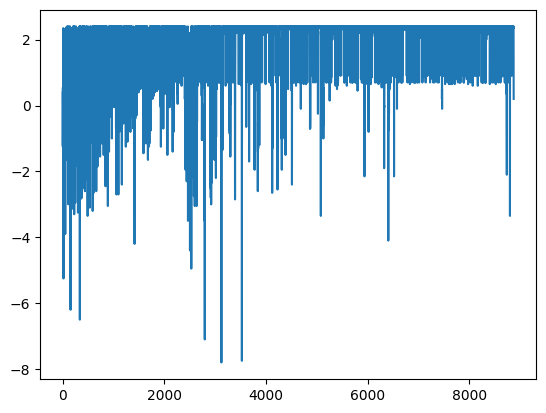

In [265]:
from matplotlib import pyplot as plt
returns = []
for episode in dataset_online.episodes:
    returns.append(episode.compute_return())
    
plt.plot(returns)

In [254]:
print(max(returns))

2.4


(array([3.00e+00, 2.00e+00, 2.00e+00, 4.00e+00, 3.20e+01, 5.20e+01,
        1.83e+02, 3.02e+02, 1.11e+03, 7.18e+03]),
 array([-7.80000019, -6.78000021, -5.76000023, -4.74000025, -3.72000003,
        -2.70000005, -1.68000007, -0.65999997,  0.36000004,  1.38000011,
         2.4000001 ]),
 <BarContainer object of 10 artists>)

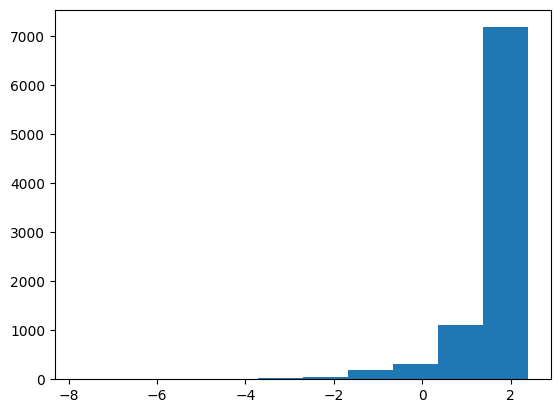

In [266]:
plt.hist(returns)

In [125]:
for episode in dataset_online.episodes:
    episode_return = episode.compute_return()
    if(episode_return >= 0.5):
        print(list(zip(episode.actions, episode.rewards, episode.observations)), episode_return)

[(1, 0.1, array([0.], dtype=float32)), (1, 0.1, array([1.], dtype=float32)), (4, 0.12, array([2.], dtype=float32)), (1, 0.2, array([4.], dtype=float32))] 0.52
[(1, 0.1, array([0.], dtype=float32)), (1, 0.1, array([1.], dtype=float32)), (4, 0.12, array([2.], dtype=float32)), (1, 0.2, array([4.], dtype=float32))] 0.52
[(1, 0.1, array([0.], dtype=float32)), (4, 0.1, array([1.], dtype=float32)), (4, 0.12, array([2.], dtype=float32)), (4, 0.2, array([4.], dtype=float32))] 0.52
[(1, 0.1, array([0.], dtype=float32)), (1, 0.1, array([1.], dtype=float32)), (4, 0.12, array([2.], dtype=float32)), (4, 0.2, array([4.], dtype=float32))] 0.52
[(1, 0.1, array([0.], dtype=float32)), (4, 0.1, array([1.], dtype=float32)), (4, 0.12, array([2.], dtype=float32)), (4, 0.2, array([4.], dtype=float32))] 0.52
[(1, 0.1, array([0.], dtype=float32)), (1, 0.1, array([1.], dtype=float32)), (4, 0.12, array([2.], dtype=float32)), (4, 0.2, array([4.], dtype=float32))] 0.52
[(1, 0.1, array([0.], dtype=float32)), (1, 0.1

In [267]:
predict_actions_for_state(dqn)

4
1
4
4
1


In [280]:
# Action value should be smallest for (s,a) = (1,4) and (2,1) since these would land you in water
# State value (approximate) should be highest
obs = np.array([4])
action_values = [dqn.predict_value([obs], np.array([action]))[0] for action in range(5)]
print(action_values)
print(np.mean(action_values))

[-0.8440419, 2.0364985, 0.6926905, 0.58478785, 2.0324836]
0.9004837


In [77]:
import d3rlpy

# prepare experience replay buffer
buffer = d3rlpy.online.buffers.ReplayBuffer(maxlen=30000, env=env)

explorer_collection = LinearDecayEpsilonGreedy(start_epsilon=1.0,
                                    end_epsilon=1.0,
                                    duration=10000)

# start data collection
dqn.collect(env, buffer, explorer=explorer, deterministic=False, n_steps=30000)

# export as MDPDataset
dataset = buffer.to_mdp_dataset()

# save MDPDataset
dataset.dump("trained_corridor_stochastic_policy_dataset_10000_collected.h5")

2023-03-15 15:55:13 [warning  ] Skip building models since they're already built.


  0%|          | 0/30000 [00:00<?, ?it/s]

In [81]:
get_episode_actions(dataset)

In [79]:
# split train and test episodes
from sklearn.model_selection import train_test_split
dataset_trained = dataset_online.load("trained_corridor_stochastic_policy_dataset_10000_collected.h5")
train_episodes, test_episodes = train_test_split(dataset_trained, test_size=0.2)

In [80]:
from d3rlpy.algos import DQN
from d3rlpy.metrics.scorer import td_error_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer
from d3rlpy.metrics.scorer import evaluate_on_environment
from d3rlpy.metrics.scorer import discounted_sum_of_advantage_scorer

# if you don't use GPU, set use_gpu=False instead.
dqn1 = DQN(batch_size=128,
          learning_rate=2.5e-5,
          target_update_interval=100,
          use_gpu=False)

# initialize neural networks with the given observation shape and action size.
# this is not necessary when you directly call fit or fit_online method.
dqn1.build_with_dataset(dataset_trained)

# calculate metrics with test dataset
td_error = td_error_scorer(dqn1, test_episodes)

# set environment in scorer function, returns mean return per episode
evaluate_scorer = evaluate_on_environment(env)

# evaluate algorithm on the environment
rewards = evaluate_scorer(dqn1)

# Use the output of learning, this is the mean reward and the most useful metric to measure learning
dqn1.fit(train_episodes,
        eval_episodes=test_episodes,
        n_epochs=10,
        scorers={
            'td_error': td_error_scorer,
            'advantage': discounted_sum_of_advantage_scorer,
            'value_scale': average_value_estimation_scorer,
            'environment': evaluate_scorer
        })

2023-03-15 15:59:03 [debug    ] RoundIterator is selected.
2023-03-15 15:59:03 [info     ] Directory is created at d3rlpy_logs/DQN_20230315155903
2023-03-15 15:59:03 [warning  ] Skip building models since they're already built.
2023-03-15 15:59:03 [info     ] Parameters are saved to d3rlpy_logs/DQN_20230315155903/params.json params={'action_scaler': None, 'batch_size': 128, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 2.5e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DQN', 'observation_shape': (1,), 'action_size': 5}


Epoch 1/10:   0%|          | 0/188 [00:00<?, ?it/s]

2023-03-15 15:59:06 [info     ] DQN_20230315155903: epoch=1 step=188 epoch=1 metrics={'time_sample_batch': 0.00030269648166413005, 'time_algorithm_update': 0.004716258099738588, 'loss': 0.07138767603665908, 'time_step': 0.005111364608115339, 'td_error': 0.15307434910779538, 'advantage': -1.1298289206879886, 'value_scale': 1.0885606996712516, 'environment': 1.8} step=188
2023-03-15 15:59:06 [info     ] Model parameters are saved to d3rlpy_logs/DQN_20230315155903/model_188.pt


Epoch 2/10:   0%|          | 0/188 [00:00<?, ?it/s]

2023-03-15 15:59:10 [info     ] DQN_20230315155903: epoch=2 step=376 epoch=2 metrics={'time_sample_batch': 0.00029795727831252077, 'time_algorithm_update': 0.004720269365513579, 'loss': 0.046491882818295284, 'time_step': 0.005100300971497881, 'td_error': 0.19694286032005479, 'advantage': -1.2759762189637294, 'value_scale': 1.6561066002705278, 'environment': 1.8} step=376
2023-03-15 15:59:10 [info     ] Model parameters are saved to d3rlpy_logs/DQN_20230315155903/model_376.pt


Epoch 3/10:   0%|          | 0/188 [00:00<?, ?it/s]

2023-03-15 15:59:20 [info     ] DQN_20230315155903: epoch=3 step=564 epoch=3 metrics={'time_sample_batch': 0.0002964494076180965, 'time_algorithm_update': 0.004635632038116455, 'loss': 0.0633906255813038, 'time_step': 0.005012365097695208, 'td_error': 0.1840618045834352, 'advantage': -1.1830831265786927, 'value_scale': 2.0438162370183854, 'environment': -100.00499999999647} step=564
2023-03-15 15:59:20 [info     ] Model parameters are saved to d3rlpy_logs/DQN_20230315155903/model_564.pt


Epoch 4/10:   0%|          | 0/188 [00:00<?, ?it/s]

2023-03-15 15:59:30 [info     ] DQN_20230315155903: epoch=4 step=752 epoch=4 metrics={'time_sample_batch': 0.0002939231852267651, 'time_algorithm_update': 0.004697670327856186, 'loss': 0.060876261819391805, 'time_step': 0.005069387719986287, 'td_error': 0.13193711155600976, 'advantage': -1.1383705080411923, 'value_scale': 2.264821973105088, 'environment': -100.14999999999645} step=752
2023-03-15 15:59:30 [info     ] Model parameters are saved to d3rlpy_logs/DQN_20230315155903/model_752.pt


In [62]:
predict_actions_for_state(dqn1)

4
1
1
4
4


In [73]:
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQL
from d3rlpy.datasets import get_cartpole
from sklearn.model_selection import train_test_split
from d3rlpy.metrics.scorer import discounted_sum_of_advantage_scorer
from d3rlpy.metrics.scorer import evaluate_on_environment
from d3rlpy.metrics.scorer import td_error_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer

# setup CQL algorithm (discrete version)
cql_stochastic = DiscreteCQL(n_frames=4, batch_size=128,
          learning_rate=2.5e-5, target_update_interval=100, use_gpu=False)

# calculate metrics with test dataset
td_error = td_error_scorer(cql_stochastic, test_episodes)

# evaluate algorithm on the environment
rewards = evaluate_scorer(ddqn)

# start training
cql_stochastic.fit(train_episodes,
        eval_episodes=test_episodes,
        n_epochs=25,
        scorers={
            'environment': evaluate_on_environment(env), # Cartpole environment
            'advantage': discounted_sum_of_advantage_scorer, # smaller is better
            'td_error': td_error_scorer, # smaller is better
            'value_scale': average_value_estimation_scorer # smaller is better
        })

2023-03-15 15:41:39 [debug    ] RoundIterator is selected.
2023-03-15 15:41:39 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230315154139
2023-03-15 15:41:39 [debug    ] Building models...
2023-03-15 15:41:39 [debug    ] Models have been built.
2023-03-15 15:41:39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 128, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 2.5e-05, 'n_critics': 1, 'n_frames': 4, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DiscreteCQL', 'observation_

Epoch 1/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:41:40 [info     ] DiscreteCQL_20230315154139: epoch=1 step=62 epoch=1 metrics={'time_sample_batch': 0.0002926357330814485, 'time_algorithm_update': 0.008014059835864652, 'loss': 1.6603110413397513, 'time_step': 0.008395798744693879, 'environment': 1.9100000000000001, 'advantage': -2.935243572532431, 'td_error': 0.3112088693505725, 'value_scale': 0.5928410644974706} step=62
2023-03-15 15:41:40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_62.pt


Epoch 2/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:41:42 [info     ] DiscreteCQL_20230315154139: epoch=2 step=124 epoch=2 metrics={'time_sample_batch': 0.0002773923258627615, 'time_algorithm_update': 0.0078505277633667, 'loss': 1.6479634796419451, 'time_step': 0.008202925805122621, 'environment': 1.81, 'advantage': -2.9841607174428924, 'td_error': 0.28423334562348646, 'value_scale': 0.7926660611365118} step=124
2023-03-15 15:41:42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_124.pt


Epoch 3/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:41:43 [info     ] DiscreteCQL_20230315154139: epoch=3 step=186 epoch=3 metrics={'time_sample_batch': 0.0002720279078329763, 'time_algorithm_update': 0.007504843896435153, 'loss': 1.5944829390894981, 'time_step': 0.007865848079804451, 'environment': 1.83, 'advantage': -2.692750062140615, 'td_error': 0.2353679752635358, 'value_scale': 0.9819855295582334} step=186
2023-03-15 15:41:43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_186.pt


Epoch 4/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:41:44 [info     ] DiscreteCQL_20230315154139: epoch=4 step=248 epoch=4 metrics={'time_sample_batch': 0.0002848525201120684, 'time_algorithm_update': 0.007563414112214119, 'loss': 1.6133197930551344, 'time_step': 0.007927917665050875, 'environment': 1.86, 'advantage': -2.8189662532880986, 'td_error': 0.2836681849812907, 'value_scale': 1.2642555547479348} step=248
2023-03-15 15:41:44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_248.pt


Epoch 5/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:41:45 [info     ] DiscreteCQL_20230315154139: epoch=5 step=310 epoch=5 metrics={'time_sample_batch': 0.00030321844162479523, 'time_algorithm_update': 0.00879336941626764, 'loss': 1.599087163325279, 'time_step': 0.0091727202938449, 'environment': 1.85, 'advantage': -2.7682487010600494, 'td_error': 0.2857497587237312, 'value_scale': 1.3889642906359525} step=310
2023-03-15 15:41:45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_310.pt


Epoch 6/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:41:46 [info     ] DiscreteCQL_20230315154139: epoch=6 step=372 epoch=6 metrics={'time_sample_batch': 0.000282226070280998, 'time_algorithm_update': 0.007308948424554641, 'loss': 1.6318211055571032, 'time_step': 0.007667299239866195, 'environment': 1.7900000000000003, 'advantage': -2.643964431489093, 'td_error': 0.31979043333097346, 'value_scale': 1.607525860708955} step=372
2023-03-15 15:41:46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_372.pt


Epoch 7/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:41:48 [info     ] DiscreteCQL_20230315154139: epoch=7 step=434 epoch=7 metrics={'time_sample_batch': 0.0002802418124291205, 'time_algorithm_update': 0.007741851191366872, 'loss': 1.644187827264109, 'time_step': 0.008091649701518397, 'environment': 1.78, 'advantage': -2.807531924889218, 'td_error': 0.39489217432158613, 'value_scale': 1.7976718970446424} step=434
2023-03-15 15:41:48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_434.pt


Epoch 8/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:41:49 [info     ] DiscreteCQL_20230315154139: epoch=8 step=496 epoch=8 metrics={'time_sample_batch': 0.00027577723226239606, 'time_algorithm_update': 0.0077009124140585625, 'loss': 1.6467038469929849, 'time_step': 0.008048057556152344, 'environment': 1.86, 'advantage': -2.7136505988061432, 'td_error': 0.38527395215313953, 'value_scale': 1.8852650783594371} step=496
2023-03-15 15:41:49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_496.pt


Epoch 9/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:41:50 [info     ] DiscreteCQL_20230315154139: epoch=9 step=558 epoch=9 metrics={'time_sample_batch': 0.0002662827891688193, 'time_algorithm_update': 0.007499856333578786, 'loss': 1.693003979421431, 'time_step': 0.007833911526587701, 'environment': 1.8400000000000003, 'advantage': -2.8053776396815704, 'td_error': 0.4798645308451474, 'value_scale': 2.112337876413937} step=558
2023-03-15 15:41:50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_558.pt


Epoch 10/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:41:51 [info     ] DiscreteCQL_20230315154139: epoch=10 step=620 epoch=10 metrics={'time_sample_batch': 0.0002656944336429719, 'time_algorithm_update': 0.007166608687370054, 'loss': 1.6955139310129228, 'time_step': 0.007504836205513247, 'environment': 1.86, 'advantage': -2.952186907452344, 'td_error': 0.5412452469930132, 'value_scale': 2.260462919789793} step=620
2023-03-15 15:41:51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_620.pt


Epoch 11/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:41:52 [info     ] DiscreteCQL_20230315154139: epoch=11 step=682 epoch=11 metrics={'time_sample_batch': 0.00025791122067359186, 'time_algorithm_update': 0.007007387376600696, 'loss': 1.7132044646047777, 'time_step': 0.00732873716662007, 'environment': 1.85, 'advantage': -2.8003551272025273, 'td_error': 0.5487207415901904, 'value_scale': 2.392331428898191} step=682
2023-03-15 15:41:52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_682.pt


Epoch 12/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:41:53 [info     ] DiscreteCQL_20230315154139: epoch=12 step=744 epoch=12 metrics={'time_sample_batch': 0.0002608568437637821, 'time_algorithm_update': 0.007024849614789409, 'loss': 1.746057350789347, 'time_step': 0.007352667470132151, 'environment': 1.8599999999999999, 'advantage': -3.0237320632996, 'td_error': 0.707512213720754, 'value_scale': 2.6542185590653378} step=744
2023-03-15 15:41:53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_744.pt


Epoch 13/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:41:54 [info     ] DiscreteCQL_20230315154139: epoch=13 step=806 epoch=13 metrics={'time_sample_batch': 0.0002501318531651651, 'time_algorithm_update': 0.006928851527552451, 'loss': 1.7424168336775996, 'time_step': 0.007241252929933609, 'environment': 1.86, 'advantage': -2.857344760831632, 'td_error': 0.6465237890685469, 'value_scale': 2.7083915930715334} step=806
2023-03-15 15:41:54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_806.pt


Epoch 14/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:41:55 [info     ] DiscreteCQL_20230315154139: epoch=14 step=868 epoch=14 metrics={'time_sample_batch': 0.0002644638861379316, 'time_algorithm_update': 0.00726553701585339, 'loss': 1.776770257180737, 'time_step': 0.0076090135881977695, 'environment': 1.85, 'advantage': -3.058858978184912, 'td_error': 0.8016583508247422, 'value_scale': 2.9739283033945028} step=868
2023-03-15 15:41:55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_868.pt


Epoch 15/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:41:56 [info     ] DiscreteCQL_20230315154139: epoch=15 step=930 epoch=15 metrics={'time_sample_batch': 0.0002545925878709362, 'time_algorithm_update': 0.006883755806953677, 'loss': 1.7868291485694148, 'time_step': 0.007210512315073321, 'environment': 1.7900000000000003, 'advantage': -3.168298750766288, 'td_error': 0.9413366388533346, 'value_scale': 3.212464904200379} step=930
2023-03-15 15:41:56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_930.pt


Epoch 16/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:41:58 [info     ] DiscreteCQL_20230315154139: epoch=16 step=992 epoch=16 metrics={'time_sample_batch': 0.0002601069788778982, 'time_algorithm_update': 0.007495080271074849, 'loss': 1.788205389053591, 'time_step': 0.007819417984254898, 'environment': 1.85, 'advantage': -3.1278892768611, 'td_error': 0.904987965224515, 'value_scale': 3.306900739182485} step=992
2023-03-15 15:41:58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_992.pt


Epoch 17/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:41:59 [info     ] DiscreteCQL_20230315154139: epoch=17 step=1054 epoch=17 metrics={'time_sample_batch': 0.00026751718213481287, 'time_algorithm_update': 0.007248197832415181, 'loss': 1.8280103187407217, 'time_step': 0.007583752755195864, 'environment': 2.04, 'advantage': -3.0024040994729178, 'td_error': 1.0383290609571603, 'value_scale': 3.5716743305987952} step=1054
2023-03-15 15:41:59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_1054.pt


Epoch 18/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:42:00 [info     ] DiscreteCQL_20230315154139: epoch=18 step=1116 epoch=18 metrics={'time_sample_batch': 0.0002637717031663464, 'time_algorithm_update': 0.007548651387614589, 'loss': 1.8192771327111028, 'time_step': 0.00788910158218876, 'environment': 1.78, 'advantage': -3.123081643664559, 'td_error': 1.055342081013316, 'value_scale': 3.693969983499027} step=1116
2023-03-15 15:42:00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_1116.pt


Epoch 19/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:42:01 [info     ] DiscreteCQL_20230315154139: epoch=19 step=1178 epoch=19 metrics={'time_sample_batch': 0.0002816300238332441, 'time_algorithm_update': 0.0077063345140026464, 'loss': 1.8259569752600886, 'time_step': 0.008074002881203928, 'environment': 1.92, 'advantage': -2.8718664393121154, 'td_error': 1.0112813409697692, 'value_scale': 3.814909639685021} step=1178
2023-03-15 15:42:01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_1178.pt


Epoch 20/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:42:02 [info     ] DiscreteCQL_20230315154139: epoch=20 step=1240 epoch=20 metrics={'time_sample_batch': 0.00026167977240777783, 'time_algorithm_update': 0.007205386315622638, 'loss': 1.8317159260472944, 'time_step': 0.007542214085978847, 'environment': 1.85, 'advantage': -3.0455336979465106, 'td_error': 1.1509721810008267, 'value_scale': 4.059253242957574} step=1240
2023-03-15 15:42:02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_1240.pt


Epoch 21/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:42:03 [info     ] DiscreteCQL_20230315154139: epoch=21 step=1302 epoch=21 metrics={'time_sample_batch': 0.00027638866055396295, 'time_algorithm_update': 0.007500194734142673, 'loss': 1.8143671212657806, 'time_step': 0.00785780337549025, 'environment': 1.85, 'advantage': -2.9802648187473975, 'td_error': 1.0021694279208093, 'value_scale': 4.065751000941866} step=1302
2023-03-15 15:42:03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_1302.pt


Epoch 22/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:42:04 [info     ] DiscreteCQL_20230315154139: epoch=22 step=1364 epoch=22 metrics={'time_sample_batch': 0.00026584825208110193, 'time_algorithm_update': 0.007086496199330976, 'loss': 1.8341128172412995, 'time_step': 0.007422958650896626, 'environment': 1.9700000000000002, 'advantage': -2.7598786754851456, 'td_error': 1.0218213218777414, 'value_scale': 4.246863104216469} step=1364
2023-03-15 15:42:04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_1364.pt


Epoch 23/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:42:06 [info     ] DiscreteCQL_20230315154139: epoch=23 step=1426 epoch=23 metrics={'time_sample_batch': 0.0002676248550415039, 'time_algorithm_update': 0.007152718882406911, 'loss': 1.8197254096308062, 'time_step': 0.007488085377600885, 'environment': 1.86, 'advantage': -2.8045920576984424, 'td_error': 1.034656147238369, 'value_scale': 4.376605877172112} step=1426
2023-03-15 15:42:06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_1426.pt


Epoch 24/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:42:07 [info     ] DiscreteCQL_20230315154139: epoch=24 step=1488 epoch=24 metrics={'time_sample_batch': 0.0002752542495727539, 'time_algorithm_update': 0.007498114339766964, 'loss': 1.809023828275742, 'time_step': 0.007843302142235541, 'environment': 1.85, 'advantage': -2.611697150057948, 'td_error': 0.8865590702559298, 'value_scale': 4.38979103300848} step=1488
2023-03-15 15:42:07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_1488.pt


Epoch 25/25:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:42:13 [info     ] DiscreteCQL_20230315154139: epoch=25 step=1550 epoch=25 metrics={'time_sample_batch': 0.0002714818523776147, 'time_algorithm_update': 0.007436040909059586, 'loss': 1.8061300208491664, 'time_step': 0.0077841704891573995, 'environment': -89.6699999999968, 'advantage': -2.2463637308965434, 'td_error': 0.8024645431373981, 'value_scale': 4.46128230662631} step=1550
2023-03-15 15:42:13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230315154139/model_1550.pt


[(1,
  {'time_sample_batch': 0.0002926357330814485,
   'time_algorithm_update': 0.008014059835864652,
   'loss': 1.6603110413397513,
   'time_step': 0.008395798744693879,
   'environment': 1.9100000000000001,
   'advantage': -2.935243572532431,
   'td_error': 0.3112088693505725,
   'value_scale': 0.5928410644974706}),
 (2,
  {'time_sample_batch': 0.0002773923258627615,
   'time_algorithm_update': 0.0078505277633667,
   'loss': 1.6479634796419451,
   'time_step': 0.008202925805122621,
   'environment': 1.81,
   'advantage': -2.9841607174428924,
   'td_error': 0.28423334562348646,
   'value_scale': 0.7926660611365118}),
 (3,
  {'time_sample_batch': 0.0002720279078329763,
   'time_algorithm_update': 0.007504843896435153,
   'loss': 1.5944829390894981,
   'time_step': 0.007865848079804451,
   'environment': 1.83,
   'advantage': -2.692750062140615,
   'td_error': 0.2353679752635358,
   'value_scale': 0.9819855295582334}),
 (4,
  {'time_sample_batch': 0.0002848525201120684,
   'time_algorit

In [74]:
predict_actions_for_state(cql_stochastic)

4
1
4
4
3


In [75]:
from d3rlpy.algos import DoubleDQN
from d3rlpy.metrics.scorer import td_error_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer
from d3rlpy.metrics.scorer import evaluate_on_environment
from d3rlpy.metrics.scorer import discounted_sum_of_advantage_scorer

# if you don't use GPU, set use_gpu=False instead.
ddqn = DoubleDQN(batch_size=128,
          learning_rate=2.5e-5,
          target_update_interval=100,
          use_gpu=False)

# initialize neural networks with the given observation shape and action size.
# this is not necessary when you directly call fit or fit_online method.
ddqn.build_with_dataset(dataset_trained)

# calculate metrics with test dataset
td_error = td_error_scorer(ddqn, test_episodes)

# set environment in scorer function, returns mean return per episode
evaluate_scorer = evaluate_on_environment(env)

# evaluate algorithm on the environment
rewards = evaluate_scorer(ddqn)

# Use the output of learning, this is the mean reward and the most useful metric to measure learning
ddqn.fit(train_episodes,
        eval_episodes=test_episodes,
        n_epochs=10,
        scorers={
            'td_error': td_error_scorer,
            'advantage': discounted_sum_of_advantage_scorer,
            'value_scale': average_value_estimation_scorer,
            'environment': evaluate_scorer
        })

2023-03-15 15:49:07 [debug    ] RoundIterator is selected.
2023-03-15 15:49:07 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_20230315154907
2023-03-15 15:49:07 [warning  ] Skip building models since they're already built.
2023-03-15 15:49:07 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_20230315154907/params.json params={'action_scaler': None, 'batch_size': 128, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 2.5e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (1,), 'action_size': 5}


Epoch 1/10:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:49:19 [info     ] DoubleDQN_20230315154907: epoch=1 step=62 epoch=1 metrics={'time_sample_batch': 0.0007490381117789976, 'time_algorithm_update': 0.004769598284075337, 'loss': 0.17385249873322825, 'time_step': 0.005634677025579637, 'td_error': 0.253805523322171, 'advantage': -1.243212240078969, 'value_scale': 0.29570150788060606, 'environment': -99.99999999999646} step=62
2023-03-15 15:49:19 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20230315154907/model_62.pt


Epoch 2/10:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:49:20 [info     ] DoubleDQN_20230315154907: epoch=2 step=124 epoch=2 metrics={'time_sample_batch': 0.00053390379874937, 'time_algorithm_update': 0.004906454393940587, 'loss': 0.1456865951298706, 'time_step': 0.005532037827276414, 'td_error': 0.2555726110079697, 'advantage': -1.9423728402815983, 'value_scale': 0.3768792274842533, 'environment': 1.7900000000000003} step=124
2023-03-15 15:49:20 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20230315154907/model_124.pt


Epoch 3/10:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:49:21 [info     ] DoubleDQN_20230315154907: epoch=3 step=186 epoch=3 metrics={'time_sample_batch': 0.00033900045579479584, 'time_algorithm_update': 0.005011773878528226, 'loss': 0.06676002399575326, 'time_step': 0.005446514775676112, 'td_error': 0.1961216797949421, 'advantage': -2.0664237626706217, 'value_scale': 0.5981387455943414, 'environment': 1.8} step=186
2023-03-15 15:49:21 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20230315154907/model_186.pt


Epoch 4/10:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:49:22 [info     ] DoubleDQN_20230315154907: epoch=4 step=248 epoch=4 metrics={'time_sample_batch': 0.00034905633618754724, 'time_algorithm_update': 0.00492748906535487, 'loss': 0.05346182256095832, 'time_step': 0.005367602071454448, 'td_error': 0.18499925195055789, 'advantage': -2.2363772313647807, 'value_scale': 0.9023596139117412, 'environment': 1.8} step=248
2023-03-15 15:49:22 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20230315154907/model_248.pt


Epoch 5/10:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:49:23 [info     ] DoubleDQN_20230315154907: epoch=5 step=310 epoch=5 metrics={'time_sample_batch': 0.00035633963923300464, 'time_algorithm_update': 0.0048727720014510615, 'loss': 0.02803400155877875, 'time_step': 0.005316199794892342, 'td_error': 0.1576052197574429, 'advantage': -2.031811093398391, 'value_scale': 0.9917120421548005, 'environment': 1.78} step=310
2023-03-15 15:49:23 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20230315154907/model_310.pt


Epoch 6/10:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:49:24 [info     ] DoubleDQN_20230315154907: epoch=6 step=372 epoch=6 metrics={'time_sample_batch': 0.00034092703173237463, 'time_algorithm_update': 0.004556302101381363, 'loss': 0.03246486744272613, 'time_step': 0.004986836064246393, 'td_error': 0.15732516126044588, 'advantage': -1.8608746977392085, 'value_scale': 1.2329559248201567, 'environment': 1.8} step=372
2023-03-15 15:49:24 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20230315154907/model_372.pt


Epoch 7/10:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:49:25 [info     ] DoubleDQN_20230315154907: epoch=7 step=434 epoch=7 metrics={'time_sample_batch': 0.0003172313013384419, 'time_algorithm_update': 0.00454227001436295, 'loss': 0.04045528506920222, 'time_step': 0.004941759570952385, 'td_error': 0.19024195330909666, 'advantage': -1.951836105383203, 'value_scale': 1.4375576965042567, 'environment': 1.8} step=434
2023-03-15 15:49:25 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20230315154907/model_434.pt


Epoch 8/10:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:49:26 [info     ] DoubleDQN_20230315154907: epoch=8 step=496 epoch=8 metrics={'time_sample_batch': 0.00030276083177135834, 'time_algorithm_update': 0.004475235939025879, 'loss': 0.03568386893358923, 'time_step': 0.004859012942160329, 'td_error': 0.15539447834026868, 'advantage': -1.7689549195039063, 'value_scale': 1.4774073119911542, 'environment': 1.8} step=496
2023-03-15 15:49:26 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20230315154907/model_496.pt


Epoch 9/10:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:49:27 [info     ] DoubleDQN_20230315154907: epoch=9 step=558 epoch=9 metrics={'time_sample_batch': 0.00029748870480445123, 'time_algorithm_update': 0.0044973242667413526, 'loss': 0.052538239637449864, 'time_step': 0.004878278701536117, 'td_error': 0.15734623482277857, 'advantage': -1.6602452260596268, 'value_scale': 1.6481526687429093, 'environment': 1.8} step=558
2023-03-15 15:49:27 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20230315154907/model_558.pt


Epoch 10/10:   0%|          | 0/62 [00:00<?, ?it/s]

2023-03-15 15:49:28 [info     ] DoubleDQN_20230315154907: epoch=10 step=620 epoch=10 metrics={'time_sample_batch': 0.0002937739895236108, 'time_algorithm_update': 0.004610465418907904, 'loss': 0.047801792922039184, 'time_step': 0.004989966269462339, 'td_error': 0.14360502034453218, 'advantage': -1.5058239971895742, 'value_scale': 1.7251256947987654, 'environment': 1.8} step=620
2023-03-15 15:49:28 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_20230315154907/model_620.pt


[(1,
  {'time_sample_batch': 0.0007490381117789976,
   'time_algorithm_update': 0.004769598284075337,
   'loss': 0.17385249873322825,
   'time_step': 0.005634677025579637,
   'td_error': 0.253805523322171,
   'advantage': -1.243212240078969,
   'value_scale': 0.29570150788060606,
   'environment': -99.99999999999646}),
 (2,
  {'time_sample_batch': 0.00053390379874937,
   'time_algorithm_update': 0.004906454393940587,
   'loss': 0.1456865951298706,
   'time_step': 0.005532037827276414,
   'td_error': 0.2555726110079697,
   'advantage': -1.9423728402815983,
   'value_scale': 0.3768792274842533,
   'environment': 1.7900000000000003}),
 (3,
  {'time_sample_batch': 0.00033900045579479584,
   'time_algorithm_update': 0.005011773878528226,
   'loss': 0.06676002399575326,
   'time_step': 0.005446514775676112,
   'td_error': 0.1961216797949421,
   'advantage': -2.0664237626706217,
   'value_scale': 0.5981387455943414,
   'environment': 1.8}),
 (4,
  {'time_sample_batch': 0.00034905633618754724,

In [76]:
predict_actions_for_state(ddqn)

4
1
1
1
4
